In [1]:
# This code performs in silico simulation for oscillations in antennal lobe.
# To execute this code, please program the vivado project "FlyOlfactoryNetwork" on the FPGA. 
# The results of the simulation are stored in ../outputs/oscillation/ folder.

In [2]:
import serial
import threading
import time
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import datetime
cmap = plt.get_cmap("tab10")

In [3]:
# please set the port name
PORT_NAME = "COM4"

# set filename of ORNcsv data
filename="../outputs/ORNcsv/ORN_3000s_osci_1odor.csv"

# Parameters for serial communication
# If you change these parameters, you must also change the vhdl code on the FPGA
BAUD_RATE = 4000000 # baud rate
NUM_DATA = 2        # a single signal (18-bits) is sent in 2 bytes
NUM_SIGNAL = 12     # the number of received signals
NUM_BIT = 18        # signals are represented by fixed-point 18 bits
DT = 0.001          # time step of the simulation [s]
LF = 10             # line feed
SEND_TW = 0.05       # interval between data transmissions
REST_TIME = 1       # additional receive time

# global flag for controlling threads
receiver_stop_flag=0

def decoder_signals(x0,x1):
    x2=((x0-2**7)*2**7+(x1-2**7))/2**8
    if x2>32:
        x2=x2-64
    return x2

def decoder_spikes(x0,x1):
    return ((x0-2**7)*2**7+(x1-2**7))

# receiver for the serial communication
    # a packet is sent from the FPGA every DT second
    # signal0: LN0_s_sum/4
    # signal1: LN1_s_sum/4
    # signal2: LN2_s_sum/4
    # signal3: LN3_s_sum/4
    # signal4: PN_s_sum/4
    # signal5: KC_s_sum/32
    # signal6: APL_v
    # signal7: MBON0_v
    # signal8: MBON1_v
    # signal9: ON_v
    # signal10: APL_v
    # signal11: PN_u_sum
def receiver(ser):
    received_data=[]
    global receiver_stop_flag
    ser.reset_input_buffer()
    print("start receiving")
    while receiver_stop_flag == 0:
        if ser.in_waiting>0:
            line0 = ser.read(ser.in_waiting)
            received_data.extend(list(line0))
    print("start decoding")
    global signals
    global spikes_x
    global spikes_y
    signals=[]
    spikes=[]
    l0=[]
    si0=[]
    sp0=[]
    while received_data[0]!=LF:
        received_data.pop(0)
    received_data.pop(0)
    for i,x in enumerate(received_data):
        if received_data[i]!=LF:
            l0.append(received_data[i])
        else:
            for j in range(int(len(l0)/NUM_DATA)):
                if j < NUM_SIGNAL:
                    if j<5:
                        si0.append(decoder_signals(l0[j*NUM_DATA],l0[j*NUM_DATA+1])*4)
                    elif j<6:
                        si0.append(decoder_signals(l0[j*NUM_DATA],l0[j*NUM_DATA+1])*32)
                    else:
                        si0.append(decoder_signals(l0[j*NUM_DATA],l0[j*NUM_DATA+1]))
                else:
                    sp0.append(decoder_spikes(l0[j*NUM_DATA],l0[j*NUM_DATA+1]))
            signals.append(si0)
            spikes.append(sp0)
            l0=[]
            si0=[]
            sp0=[]
    signals = pd.DataFrame(signals).T.values.tolist()
    spikes_x=[]
    spikes_y=[]
    for i,l in enumerate(spikes):
        for x in l:
            spikes_x.append(i*DT)
            spikes_y.append(x)
    return signals,spikes_x,spikes_y

# encode a signal to 2-byte data
def encode_signal(x):
    if x>=2525+11:
        raise ValueError('too large signal')
    I0=int(int(x/2**6)+2**7)
    I1=int(x%2**6+2**6)
    return [I0, I1]

# class for transmitter of the serial communication
    # a block of packets is sent to the FPGA every SEND_TW second and stored FIFO buffer
    # packets are processed every DT second in FPGA
    # list of signals
      # 0: not used
      # 1: reward signal for LTD
      # 2: LTD reset
      # 3: PN homeostasis start
      # 4: PN homeostasis end
      # 5: LN0 onoff
      # 6: LN1 onoff
      # 7: LN2 onoff
      # 8: LN3 onoff
      # 9: PQN start
      # 10: next time step
      # 11--2536 : addrass of ORN that spikes in this time step - 11
class send_data:
    def __init__(self,tmax):
        self.command_list=[]
        self.packet_list=[]
        self.tmax=tmax
        self.ORNdata = pd.read_csv(filename, header=None).values.tolist()
    def set_command(self,t0,x0):
        self.command_list.append([t0,x0])
    def generate_packet_list(self):
        c0=0
        packet=[]
        for i in range(int((self.tmax+1)/DT)):
            while self.ORNdata[c0][0] <= i*DT:
                packet.extend(encode_signal(self.ORNdata[c0][1]+LF+1))
                c0+=1
            for j, x in enumerate(self.command_list):
                if i==int(x[0]/DT):
                    print("inserted", i*DT, "[s], command=", x[1])
                    packet.extend(encode_signal(x[1]))
            packet.extend(encode_signal(LF))
            if i%(int(SEND_TW/DT))==int(SEND_TW/DT)-1:
                self.packet_list.append(packet)
                packet=[]

    def packet_get(self):
        if len(self.packet_list)>0:
            return self.packet_list.pop(0)
    def print_vhdl_line(self,f0,x):
        f0.write("    -- "+str(x)+"\n")
        f0.write("    wait for "+str(int(10**9/BAUD_RATE))+" ns ; uart_rxd <= '0' ;\n")
        y=[]
        for i in range(8):
            if x>=2**(7-i):
                y.append(1)
                x=x-2**(7-i)
            else:
                y.append(0)
        for i in range(8):
            f0.write("    wait for "+str(int(10**9/BAUD_RATE))+" ns ; uart_rxd <= '"+str(y[7-i])+"' ;\n")
        f0.write("    wait for "+str(int(10**9/BAUD_RATE))+" ns ; uart_rxd <= '1' ;\n")
    def print_vhdl_sim(self,filename,t0):
        f0 = open(filename, 'w')
        c0=0
        for packet in self.packet_list:
            if c0*SEND_TW>t0:
                break
            for x in packet:
                self.print_vhdl_line(f0,x)
            f0.write("    -- 0.1s interval\n")
            f0.write("    wait for "+str(int(SEND_TW*10**9))+" ns ; uart_rxd <= '1' ;\n")
            c0+=1
        f0.close()

class serial_test:
    def __init__(self,tmax):
        self.tmax=tmax
        self.d0=send_data(tmax)
    def set_command(self,t0,x0):
        self.d0.set_command(t0,x0)
    def run(self):
        self.d0.generate_packet_list()
        self.d0.print_vhdl_sim("vhdl_sim.txt",0.001)
        ser = serial.Serial(PORT_NAME, baudrate=BAUD_RATE, bytesize=serial.EIGHTBITS, parity=serial.PARITY_NONE)
        ser.set_buffer_size(rx_size=12800, tx_size=12800)
        thread1 = threading.Thread(target=receiver, args=(ser,))
        thread1.start()
        t1=time.time()
        t2=time.time()
        k0=0
        for i in range(7):
            ser.write(self.d0.packet_get())
        while t2-t1<self.tmax:
            ser.write(self.d0.packet_get())
            k0+=1
            t2=time.time()
            if SEND_TW*k0-(t2-t1)>0:
                time.sleep(SEND_TW*k0-(t2-t1))
        global receiver_stop_flag
        time.sleep(REST_TIME)
        receiver_stop_flag=1
        thread1.join()
        ser.close()
        return signals,spikes_x,spikes_y

In [4]:
num_trial=20
duration=num_trial*20
homeostasis_duration=300

# length of simulation [s]
tmax=2400

# set serial communication
se0=serial_test(tmax)
se0.set_command(0,9)
se0.set_command(0,3)
se0.set_command(homeostasis_duration,4)

se0.set_command(homeostasis_duration+duration,5)
se0.set_command(homeostasis_duration+duration*2,5)
se0.set_command(homeostasis_duration+duration*2,6)
se0.set_command(homeostasis_duration+duration*3,6)
se0.set_command(homeostasis_duration+duration*3,7)
se0.set_command(homeostasis_duration+duration*4,7)
se0.set_command(homeostasis_duration+duration*4,8)

In [5]:
# run serial communication
signals,spikes_x,spikes_y=se0.run()

inserted 0.0 [s], command= 9
inserted 0.0 [s], command= 3
inserted 300.0 [s], command= 4
inserted 700.0 [s], command= 5
inserted 1100.0 [s], command= 5
inserted 1100.0 [s], command= 6
inserted 1500.0 [s], command= 6
inserted 1500.0 [s], command= 7
inserted 1900.0 [s], command= 7
inserted 1900.0 [s], command= 8
start receiving
start decoding


In [6]:
P=6
odor_duration=10
LN_max=191
PN_max=312

In [7]:
import pickle
def save_data(data,fname):
    file = open(fname+".txt", 'wb')
    pickle.dump(data, file)
def save_signal(signal,start,end,fname):
    save_data(signal[int(start/DT):int(end/DT)],fname)    

folder="../outputs/oscillation/"
save_data(signals[0],folder+"LN0")
save_data(signals[1],folder+"LN1")
save_data(signals[2],folder+"LN2")
save_data(signals[3],folder+"LN3")
save_data(signals[4],folder+"PN")
save_data(signals[5],folder+"KC")

In [8]:
def read_data(filename):
    f = open(filename+".txt","rb")
    x = pickle.load(f)
    return x

LN0=read_data(folder+"LN0")
LN1=read_data(folder+"LN1")
LN2=read_data(folder+"LN2")
LN3=read_data(folder+"LN3")
PN=read_data(folder+"PN")
KC=read_data(folder+"KC")
t0=[]
for i in range(len(LN0)):
    t0.append(i*DT)
LN0=[x0/48 for x0 in LN0]
LN1=[x0/48 for x0 in LN1]
LN2=[x0/48 for x0 in LN2]
LN3=[x0/47 for x0 in LN3]
PN=[x0/121 for x0 in PN]
KC=[x0/1919 for x0 in KC]
LN=[(x0*48+x1*48+x2*48+x3*47)/191 for (x0, x1, x2, x3) in zip(LN0, LN1, LN2, LN3)]

save_signal(LN0,homeostasis_duration,homeostasis_duration+duration,folder+"LN0_normal")
save_signal(LN1,homeostasis_duration,homeostasis_duration+duration,folder+"LN1_normal")
save_signal(LN2,homeostasis_duration,homeostasis_duration+duration,folder+"LN2_normal")
save_signal(LN3,homeostasis_duration,homeostasis_duration+duration,folder+"LN3_normal")
save_signal(LN,homeostasis_duration,homeostasis_duration+duration,folder+"LN_normal")
save_signal(PN,homeostasis_duration,homeostasis_duration+duration,folder+"PN_normal")
save_signal(KC,homeostasis_duration,homeostasis_duration+duration,folder+"KC_normal")
save_signal(t0,0,duration,folder+"t0_normal")
save_signal(PN,homeostasis_duration+duration*1,homeostasis_duration+duration*2,folder+"PN_LN0inact")
save_signal(PN,homeostasis_duration+duration*2,homeostasis_duration+duration*3,folder+"PN_LN1inact")
save_signal(PN,homeostasis_duration+duration*3,homeostasis_duration+duration*4,folder+"PN_LN2inact")
save_signal(PN,homeostasis_duration+duration*4,homeostasis_duration+duration*5,folder+"PN_LN3inact")

### 

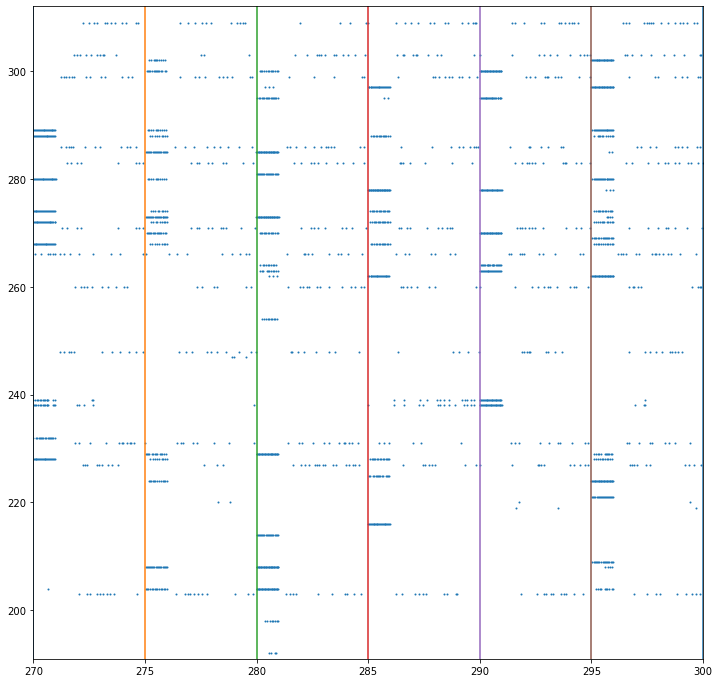

In [9]:
plt.figure(figsize=(12,12))
xmin=homeostasis_duration-30
xmax=homeostasis_duration-0
spikes_x_0 = [x for x in spikes_x if xmin <= x < xmax]
spikes_y_0 = [spikes_y[i] for i, x in enumerate(spikes_x) if xmin <= x < xmax]
plt.scatter(spikes_x_0,spikes_y_0,s=1)
plt.xlim(xmin,xmax)
plt.ylim(LN_max,PN_max)
cmap = plt.get_cmap("tab10")
for j in range(int(tmax/5)):
    plt.plot([5*j,5*j],[LN_max,PN_max],color=cmap(j%P))

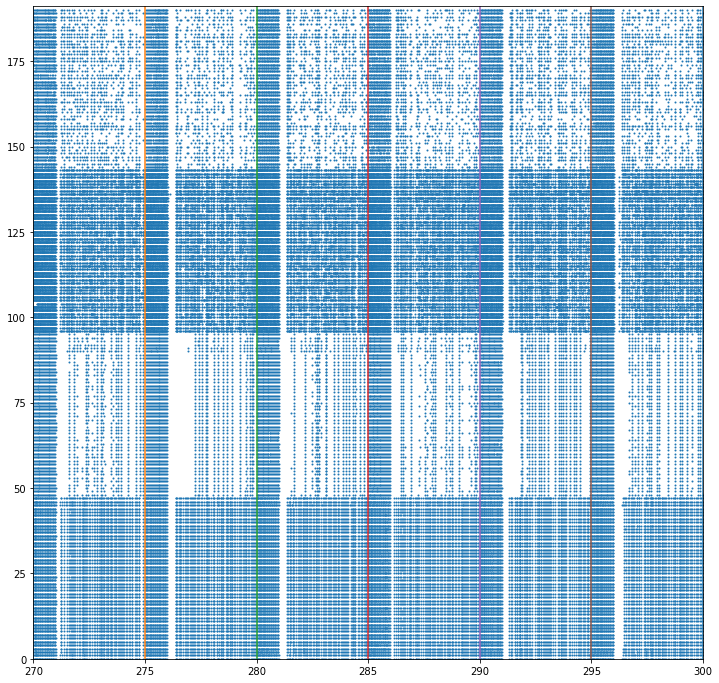

In [10]:
plt.figure(figsize=(12,12))
xmin=homeostasis_duration-30
xmax=homeostasis_duration-0
spikes_x_0 = [x for x in spikes_x if xmin <= x < xmax]
spikes_y_0 = [spikes_y[i] for i, x in enumerate(spikes_x) if xmin <= x < xmax]
plt.scatter(spikes_x_0,spikes_y_0,s=1)
plt.xlim(xmin,xmax)
plt.ylim(0,LN_max)
cmap = plt.get_cmap("tab10")
for j in range(int(tmax/5)):
    plt.plot([5*j,5*j],[0,LN_max],color=cmap(j%P))